# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import dill
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 10 # 20
thresholds = np.round(np.arange(0.6,1.00001,0.025), 2) #np.round(np.arange(0.6,1.00001,0.01), 2)

### Utility functions

In [2]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221109_2030_allRegions/radiomicFeatures/radiomicFeatures.csv'))
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# open reproducibility data
dfRadRep = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221109_1137_repro/radiomicFeatures/radiomicFeatures.csv'))
dfRadRep.drop(list(dfRadRep.filter(regex = 'source')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'histogram')), axis = 1, inplace = True)

## Compute ICCs and remove unreproducible features

In [5]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)

dfRad.shape

(170, 90)

## Create output and copy code

In [6]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))

    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection.ipynb'))

    file = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

## Run classifications

### Tumour type: LMS v.s LPS
### Standard radiomics features

In [7]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original'

df = df.filter(regex=featureSet + '|' + target)

In [8]:
# with open('/Users/morton/Documents/git/git_radsarc/classification/debugVariables.pickle', 'wb') as handle:
#     pickle.dump({'df':df, 'target':target, 'settings':settings}, handle)

In [9]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)
    
resultStandardType = copy.deepcopy(result)

del result
    

Threshold = 0.6
shape|firstorder
AUROC = 0.887 ± 0.088

Threshold = 0.62
shape|firstorder
AUROC = 0.897 ± 0.0882

Threshold = 0.65
shape|firstorder
AUROC = 0.903 ± 0.0835

Threshold = 0.68
shape|firstorder
AUROC = 0.899 ± 0.085

Threshold = 0.7
shape|firstorder
AUROC = 0.898 ± 0.0847

Threshold = 0.73
shape|firstorder
AUROC = 0.9 ± 0.0848

Threshold = 0.75
shape|firstorder
AUROC = 0.899 ± 0.0846

Threshold = 0.78
shape|firstorder
AUROC = 0.899 ± 0.0847

Threshold = 0.8
shape|firstorder
AUROC = 0.898 ± 0.0859

Threshold = 0.83
shape|firstorder
AUROC = 0.897 ± 0.0881

Threshold = 0.85
shape|firstorder
AUROC = 0.897 ± 0.0881

Threshold = 0.88
shape|firstorder
AUROC = 0.898 ± 0.0876

Threshold = 0.9
shape|firstorder
AUROC = 0.898 ± 0.0859

Threshold = 0.93
shape|firstorder
AUROC = 0.903 ± 0.0816

Threshold = 0.95
firstorder|texture
AUROC = 0.906 ± 0.085

Threshold = 0.98
shape|firstorder
AUROC = 0.903 ± 0.0873

Threshold = 1.0
firstorder|texture
AUROC = 0.905 ± 0.0848



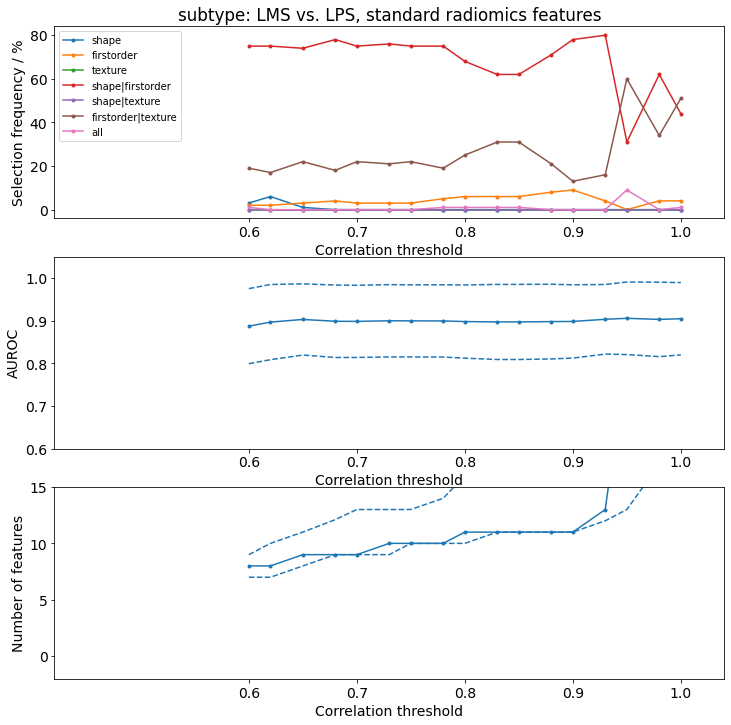

In [10]:
plotResultExperiments(resultStandardType, titleStr=target + ': LMS vs. LPS, standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultStandardType, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()

### Tumour type: LMS v.s LPS
### Volume fraction and standard radiomics features

In [11]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original|sarcomaFeature'

df = df.filter(regex=featureSet + '|' + target)

In [12]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolFracType = copy.deepcopy(result)

del result
    

Threshold = 0.6
VolumeFraction|shape
AUROC = 0.893 ± 0.0789

Threshold = 0.62
VolumeFraction|shape


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/adminehann/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-be531d7e2326>", line 12, in <module>
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)
  File "/Users/adminehann/Documents/git/git_radsarc/classification/fit_LR_groupSelection_correlationThresholds.py", line 137, in fit_LR_groupSelection_correlationThresholds
    cv_result = cross_validate(model, X, y, cv=validation, scoring='roc_auc', return_estimator=True, n_jobs=n_jobs)
  File "/Users/adminehann/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/Users/adminehann/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 248, in cross_validate
    for train, test in cv.split

TypeError: object of type 'NoneType' has no len()

In [ ]:
plotResultExperiments(resultVolFracType, titleStr = target + ': LMS vs. LPS, volume fraction + standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultVolFracType, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Standard radiomics features

In [ ]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

In [ ]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultStandardGrade_1vs23 = copy.deepcopy(result)

del result
    

In [ ]:
plotResultExperiments(resultStandardGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_1vs23, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Standard radiomics features

In [ ]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

In [ ]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultStandardGrade_12vs3 = copy.deepcopy(result)

del result
    

In [ ]:
plotResultExperiments(resultStandardGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_12vs3, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Volume fractions and standard radiomics features

In [ ]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original|sarcomaFeature'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

In [ ]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolumeFractionGrade_1vs23 = copy.deepcopy(result)

del result
    

In [ ]:
plotResultExperiments(resultVolumeFractionGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 volume fractions + standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_1vs23, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Volume fractions + standard radiomics features 

In [ ]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original|sarcomaFeature'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

In [ ]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolumeFractionGrade_12vs3 = copy.deepcopy(result)

del result
    

In [ ]:
plotResultExperiments(resultVolumeFractionGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 volume fraction + standard radiomics features')

if False:
    bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_12vs3, threshold=0.8)
    # bestCoef.style.hide_index()
    pdFreq.style.hide_index()